In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 1498,
    chunk_overlap= 198,
)

loader = Docx2txtLoader('./tax.docx')
temp = loader.load_and_split(text_splitter=text_splitter)

document_list = temp[0:80]
len(document_list)

80

In [4]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-large')

### 처음 데이터 생성 시에만 확인하기 //// 데이터 로딩

In [5]:
from langchain_chroma import Chroma

# 처음 데이터 생성 시에만
# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name='chroma-tax',
#     persist_directory='./chroma-tax'
# )

## 데이터 로딩 
vector_store = Chroma(
    collection_name='chroma-tax',
    embedding_function=embedding,
    persist_directory='./chroma-tax'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

### 랭그래프 시작 , state, node, edge

In [6]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

### 내가 해본 방법

In [1]:
# 검색
def retrieve(state: AgentState) -> AgentState:
    query = state["query"]
    docs = retriever.get_relevant_documents(query)
    return {**state, "context": docs}

# 답변 생성
def generate(state: AgentState) -> AgentState:
    context_texts = "\n".join([d.page_content for d in state["context"]])
    answer = llm.invoke(f"질문: {state['query']}\n\n참고 문맥:\n{context_texts}")
    return {**state, "answer": answer.content}

# 질문 리라이트
def rewrite(state: AgentState) -> AgentState:
    new_query = llm.invoke(f"다음 질문을 더 검색 친화적으로 다시 써줘: {state['query']}")
    return {**state, "query": new_query.content}

NameError: name 'AgentState' is not defined

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

# 노드 등록
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node("rewrite", rewrite)

# 분기 연결
builder.add_edge(START, "retrieve")

# retrieve → generate or rewrite (조건 분기)
def branch_after_retrieve(state: AgentState):
    if len(state["context"]) > 0:   
        return "generate"
    else:                           
        return "rewrite"

builder.add_conditional_edges("retrieve", branch_after_retrieve,
                              {"generate": "generate", "rewrite": "rewrite"})

# generate → END
builder.add_edge("generate", END)

# rewrite → retrieve (루프)
builder.add_edge("rewrite", "retrieve")

graph = builder.compile()


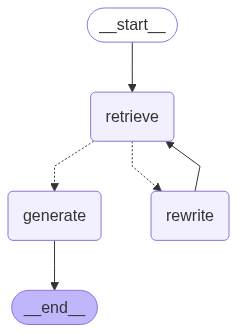

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"query": "연봉 5천만원 직장인의 소득세는? ", "context": [], "answer": ""}
result = graph.invoke(inputs)
print(result["answer"])

C:\Users\USER\AppData\Local\Temp\ipykernel_17032\3918439501.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


연봉 5천만원을 받는 직장인의 소득세는 다음과 같이 대략적으로 계산할 수 있습니다. 한국의 소득세는 누진세 구조로 되어 있어, 소득 구간에 따라 세율이 다르게 적용됩니다.

2023년 기준으로, 개인소득세의 세율은 다음과 같습니다:

- 1,200만원 이하: 6%
- 1,200만원 초과 ~ 4,600만원 이하: 15%
- 4,600만원 초과 ~ 8,800만원 이하: 24%

연봉 5천만원의 경우, 세금 계산은 다음과 같습니다.

1. **과세표준 계산**: 연봉 5천만원에서 비과세 소득이나 공제를 제외한 금액을 과세표준으로 합니다. 여기서는 간단화를 위해 비과세 소득이나 공제를 고려하지 않고 계산하겠습니다.

2. **소득세 계산**:
   - 1,200만원까지: 1,200만원 × 6% = 72만원
   - 1,200만원 초과 4,600만원까지: (4,600만원 - 1,200만원) × 15% = 51만원
   - 4,600만원 초과 5,000만원까지: (5,000만원 - 4,600만원) × 24% = 96만원

3. **총 소득세**: 
   - 72만원 + 51만원 + 96만원 = 219만원

따라서, 연봉 5천만원을 받는 직장인의 대략적인 소득세는 약 219만원입니다. 다만, 개인의 세무 상황에 따라 공제 항목이나 추가 세금이 있을 수 있으므로, 정확한 세액은 세무사와 상담하거나 국세청의 세금 계산기를 이용하는 것이 좋습니다.


### 강사님 버전

In [20]:
from langchain import hub

generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    """ 
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.        
    """
    context = state['context']
    query = state['query']

    rag_chain = generate_prompt | llm

    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response}

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [13]:
from langchain import hub
from typing import Literal

doc_releveance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevence(state: AgentState) -> Literal['generate', 'rewrite']:
    """ 
    주어진 state를 기반으로 문서의 관련성을 판단합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇치 않으면 'rewrite' 를 반환합니다.       
    """

    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_releveance_prompt | llm

    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

c:\workspace\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리 사전을 참고해서 사용자의 질문을 변경해 주세요.
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state=AgentState) -> AgentState:
    """
    사용자의 질문을 사전에 고려하여 변경합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state
    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.   
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})

    return {'query': response}

In [21]:
builder = StateGraph(AgentState)

builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node('rewrite', rewrite)

In [22]:
from langgraph.graph import START, END

builder.add_edge(START, 'retrieve')
builder.add_conditional_edges('retrieve', check_doc_relevence)
builder.add_edge('rewrite', 'retrieve')
builder.add_edge('generate', END)

In [ ]:
graph = builder.compile()

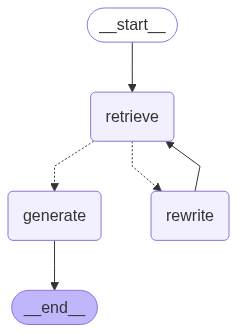

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# test
initial_state = {"query": "연봉 5천만원 직장인의 소득세는?"}
response = graph.invoke(initial_state)

In [ ]:
response

{'query': '질문을 변경할 필요가 없습니다. 사용자의 질문은 소득세에 관한 것이며, 주어진 사전과 관련이 없습니다.',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='[시행일: 2025. 1. 1.]  제21조제1항 각 호 외의 부분, 제21조제1항제27호\n\n\n\n제22조(퇴직소득) ① 퇴직소득은 해당 과세기간에 발생한 다음 각 호의 소득으로 한다. <개정 2013. 1. 1.>\n\n1. 공적연금 관련법에 따라 받는 일시금\n\n2. 사용자 부담금을 기초로 하여 현실적인 퇴직을 원인으로 지급받는 소득\n\n3. 그 밖에 제1호 및 제2호와 유사한 소득으로서 대통령령으로 정하는 소득\n\n② 제1항제1호에 따른 퇴직소득은 2002년 1월 1일 이후에 납입된 연금 기여금 및 사용자 부담금을 기초로 하거나 2002년 1월 1일 이후 근로의 제공을 기초로 하여 받은 일시금으로 한다.<개정 2013. 1. 1.>\n\n③퇴직소득금액은 제1항 각 호에 따른 소득의 금액의 합계액(비과세소득의 금액은 제외한다)으로 한다. 다만, 대통령령으로 정하는 임원의 퇴직소득금액(제1항제1호의 금액은 제외하며, 2011년 12월 31일에 퇴직하였다고 가정할 때 지급받을 대통령령으로 정하는 퇴직소득금액이 있는 경우에는 그 금액을 뺀 금액을 말한다)이 다음 계산식에 따라 계산한 금액을 초과하는 경우에는 제1항에도 불구하고 그 초과하는 금액은 근로소득으로 본다.<개정 2012. 1. 1., 2013. 1. 1., 2014. 12. 23., 2019. 12. 31.>\n\n\n\n④ 제3항 단서와 그 계산식을 적용할 때 근무기간과 총급여는 다음 각 호의 방법으로 산정한다.<개정 2014. 12. 23.>\n\n1. 근무기간: 개월 수로 계산한다. 이 경우 1개월 미만의 기간이 있는 경우에는 이를 1개월로 본다.\n\n2. 총급여: 봉급ㆍ상여 등 제20조제1항제1호 및 제2호에 따른 근로소득(제12조에

In [ ]:
print(response['answer'].content)

질문을 변경할 필요가 없습니다. 사용자의 질문은 소득세에 관한 것이며, 주어진 사전과 관련이 없습니다.
